In [24]:
import networkx as nx
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon
import osmnx as ox
import os
%matplotlib inline

#ox.settings.use_cache = True

In [25]:
EUP_gdf = gp.read_file('../DATA/EUPPlanning_Region.shp.zip')
EUPCounties_gdf = gp.read_file('../DATA/EUPCounties.shp.zip')
EUPTowns_gdf = gp.read_file('../DATA/EUPTowns.shp.zip')

<Axes: >

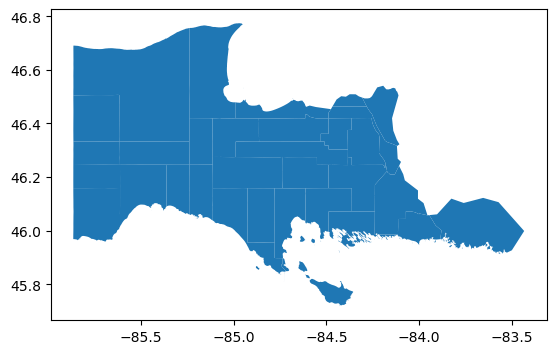

In [26]:
EUPTowns_gdf.plot()

<Axes: >

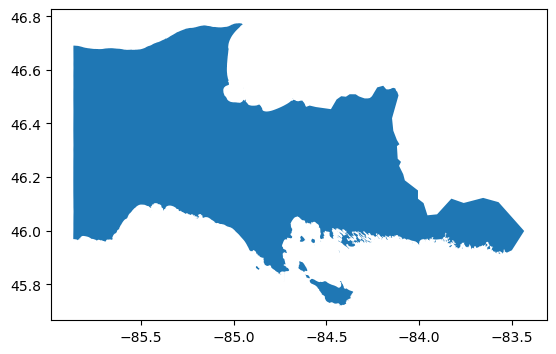

In [27]:
EUP_gdf.plot()

<Axes: >

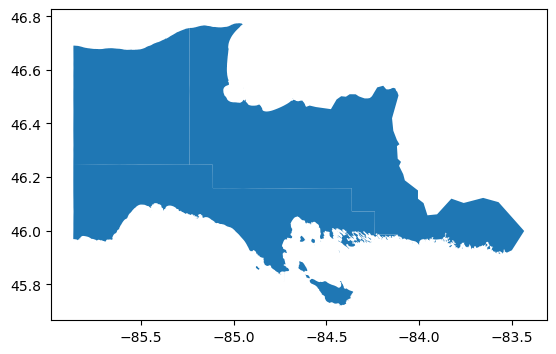

In [28]:
EUPCounties_gdf.plot()

In [29]:
def extract_polygons_from_gdf(gdf):
    """
    Extracts individual polygons from a GeoDataFrame.

    Args:
        gdf (geopandas.GeoDataFrame): The GeoDataFrame containing geometries.

    Returns:
        list: A list of individual Polygon objects.
    """
    coords_list = []

    for index, row in gdf.iterrows():
        geom = row['geometry']

        if geom.geom_type == 'Polygon':
            print(f'Polygon found at index {index}')
            coords_list.append(Polygon(list(geom.exterior.coords)))

        elif geom.geom_type == 'MultiPolygon':
            print(f'MultiPolygon found at index {index}')
            geoms = list(geom.geoms)
            print(f'Number of sub-polygons: {len(geoms)}')
            multicoords_list = [Polygon(list(sub_geom.exterior.coords)) for sub_geom in geoms if sub_geom.geom_type == 'Polygon']
            print(f'Number of extracted sub-polygons: {len(multicoords_list)}')
            coords_list.extend(multicoords_list)

    return coords_list

# Example usage:
# extracted_polygons = extract_polygons_from_gdf(EUP_gdf)

In [30]:
def create_combined_graph_from_polygons(coords_list):
    """
    Creates a combined graph from a list of polygons.

    Args:
        coords_list (list): A list of Shapely Polygon objects.

    Returns:
        networkx.Graph: A combined graph containing road networks from the input polygons.
    """
    G1 = nx.Graph()

    for i, polygon in enumerate(coords_list):
        exterior_ring = polygon.exterior

        try:
            if G1:
                G2 = ox.graph_from_polygon(Polygon(exterior_ring), network_type='drive_service', simplify=True, retain_all=True, truncate_by_edge=False, custom_filter=None)
                G1 = nx.compose(G1, G2)
                #print(f"Success inside {i}")
            else:
                G1 = ox.graph_from_polygon(Polygon(exterior_ring), network_type='drive_service', simplify=True, retain_all=True, truncate_by_edge=False, custom_filter=None)
                #print(f"Success outside {i}")

        except ValueError as e:
            next
            #print(f"Error processing polygon: {e} at index {i}")
        except nx.NetworkXPointlessConcept as npce:
            next
            #print(f"NetworkXPointlessConcept: {npce} at index {i}")

    return G1

# Example usage:
# combined_graph = create_combined_graph_from_polygons(coords_list)



In [31]:
# Sample Code from NetworkX documentation - updated for 1.9 version of osmnx


# download street network data from OSM and construct a MultiDiGraph model

G = create_combined_graph_from_polygons(extract_polygons_from_gdf(EUP_gdf))

# save graph as a geopackage or graphml file
#ox.io.save_graph_geopackage(G, filepath="./graph.gpkg")


MultiPolygon found at index 0
Number of sub-polygons: 150
Number of extracted sub-polygons: 150


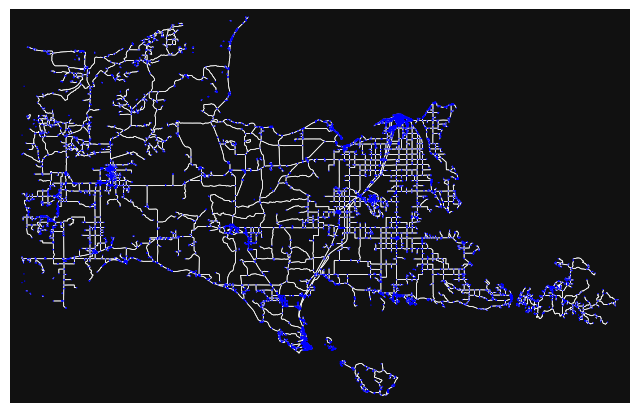

In [33]:
fig, ax = ox.plot_graph(G, node_size=1, node_color='b', edge_color='w', edge_linewidth=0.5)

In [34]:
ox.io.save_graph_geopackage(G, filepath="../DATA/EUPOSMgraph.gpkg")

## Samples

osmnx.features.features_from_polygon(polygon, tags)
Create GeoDataFrame of OSM features within boundaries of a (multi)polygon.

You can use the settings module to retrieve a snapshot of historical OSM data as of a certain date, or to configure the Overpass server timeout, memory allocation, and other custom settings.

For more details, see: https://wiki.openstreetmap.org/wiki/Map_features

PARAMETERS:
polygon (shapely.geometry.Polygon or shapely.geometry.MultiPolygon) – geographic boundaries to fetch features within

tags (dict) – Dict of tags used for finding elements in the selected area. Results returned are the union, not intersection of each individual tag. Each result matches at least one given tag. The dict keys should be OSM tags, (e.g., building, landuse, highway, etc) and the dict values should be either True to retrieve all items with the given tag, or a string to get a single tag-value combination, or a list of strings to get multiple values for the given tag. For example, tags = {‘building’: True} would return all building footprints in the area. tags = {‘amenity’:True, ‘landuse’:[‘retail’,’commercial’], ‘highway’:’bus_stop’} would return all amenities, landuse=retail, landuse=commercial, and highway=bus_stop.

RETURNS:
gdf

RETURN TYPE:
geopandas.GeoDataFrame